In [8]:
def run_esn_quantization(N, bit_width):
    from reservoirpy.datasets import rossler
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    from brevitas.nn import QuantIdentity
    import numpy as np
    import torch
    from reservoirpy import Node

    # Prepare Lorenz dataset
    X = rossler(10000)
    X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

    train_len = 5000
    threshold_scale = 1.0 / (2 ** bit_width) 

    # Initialize and train ESN (FP32)
    reservoir = Reservoir(N, lr=1, sr=0.9, input_connectivity=0.9, rc_connectivity=0.1, input_scaling=1)
    readout = Ridge(ridge=1e-2)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(X[:train_len], X[1:train_len + 1], warmup=1000)

    # Quantization helper
    def extract_Qinput(input_array, num_bits):
        quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
        float_input = torch.tensor(input_array, dtype=torch.float64)
        quant_input = quant_identity(float_input)
        return (
            quant_input.int().detach().numpy(),
            quant_input.scale.detach().numpy(),
            quant_input.zero_point.detach().numpy()
        )

    # Extract quantized versions
    int_x, x_scale, _ = extract_Qinput(X, num_bits=bit_width)
    int_Win, scale_Win, _ = extract_Qinput(esn_model.nodes[0].Win.todense(), num_bits=bit_width)
    int_Wr, scale_Wr, _ = extract_Qinput(esn_model.nodes[0].W.todense(), num_bits=bit_width)
    int_bias, _, _ = extract_Qinput(esn_model.nodes[0].bias.todense(), num_bits=bit_width)

    input_scale = (scale_Win * x_scale)
    reservoir_scale = (scale_Wr * threshold_scale)

    def compute_integer_thresholds(scale):
        return np.int32(-1 / scale), np.int64(1 / scale)

    a_scaled, b_scaled = compute_integer_thresholds(input_scale)
    c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

    def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, div_scale):
        x = np.clip(x, a_scaled, b_scaled)
        x = x + b_scaled
        return (x / div_scale).astype(np.int64)

    div_scale = 2 ** bit_width

    def forward2(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int64).reshape(1, N)
        r = state @ node.Wr.astype(np.int64)
        s = x @ node.Win.astype(np.int64).T
        s = s.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, div_scale)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, div_scale)
        return out_r + out_s + node.Bias.reshape(1, N)

    def initialize(node: Node, x: np.ndarray = None, y: np.ndarray = None):
        if x is not None:
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Wr", int_Wr)
            node.set_param("Win", int_Win)
            node.set_param("Bias", int_bias)

    class CustomNode(Node):
        def __init__(self, name=None):
            super().__init__(
                forward=forward2,
                initializer=initialize,
                params={"Wr": None, "Win": None, "Bias": None},
                hypers={},
                name=name
            )

    node = CustomNode(name=f"quant_reservoir_N{N}_b{bit_width}")
    esn_model_PTQ = node >> readout

    Quantized_States = node.run(int_x[:train_len].astype(np.float64)) * threshold_scale
    readout.fit(Quantized_States, X[1:train_len + 1], warmup=1000)

    Quantized_States_test = node.run(int_x[train_len+1:-1].astype(np.float64)) * threshold_scale
    Y_pred_PTQ = readout.run(Quantized_States_test)

    # Evaluation
    a="R\u00B2"

    Y_true = X[train_len + 2:]
    return {
        "N": N,
        "bits": bit_width,
        "RMSE": rmse(Y_true, Y_pred_PTQ),
        "NRMSE": nrmse(Y_true, Y_pred_PTQ),
        "R\u00B2": rsquare(Y_true, Y_pred_PTQ)
    }

 

In [9]:
def run_esn_float(N):
    from reservoirpy.datasets import rossler
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    import numpy as np

    # Prepare Lorenz dataset
    X = rossler(10000)
    X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

    train_len = 5000

    reservoir = Reservoir(N, lr=1, sr=0.9, input_connectivity=0.9, rc_connectivity=0.1, input_scaling=1)
    readout = Ridge(ridge=1e-2)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(X[:train_len], X[1:train_len + 1], warmup=1000)

    Y_pred = esn_model.run(X[train_len:-1])
    Y_true = X[train_len + 1:]

    return {
        "N": N,
        "bits": "FP",
        "RMSE": rmse(Y_true, Y_pred),
        "NRMSE": nrmse(Y_true, Y_pred),
        "R\u00B2": rsquare(Y_true, Y_pred)
    }


In [10]:
# Define parameter sets
N_list = [50,100, 150, 200, 250, 300, 350, 400, 450, 500]
bit_width_list = [4, 6, 8,16]

results = []

# Step 1: Run float (baseline) for each N
for N in N_list:
    print(f"Running float (FP32) evaluation for N={N}...")
    float_result = run_esn_float(N)
    results.append(float_result)

# Step 2: Run quantized evaluations
for N in N_list:
    for bits in bit_width_list:
        print(f"Running quantized evaluation for N={N}, bit_width={bits}...")
        quant_result = run_esn_quantization(N, bits)
        results.append(quant_result)

# Step 3: Create DataFrame and save
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)

# Optional: Save to CSV
df_results.to_csv("quantized_and_float_esn_results.csv", index=False)


Running float (FP32) evaluation for N=50...


Running Model-90: 5000it [00:00, 17778.11it/s]?, ?it/s]
Running Model-90: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-50...


Running Model-90: 4999it [00:00, 19660.23it/s]         


Running float (FP32) evaluation for N=100...


Running Model-91: 5000it [00:00, 17993.44it/s]?, ?it/s]
Running Model-91: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Fitting node Ridge-51...


Running Model-91: 4999it [00:00, 19297.76it/s]         


Running float (FP32) evaluation for N=150...


Running Model-92: 5000it [00:00, 17613.28it/s]?, ?it/s]
Running Model-92: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-52...


Running Model-92: 4999it [00:00, 18846.68it/s]         


Running float (FP32) evaluation for N=200...


Running Model-93: 5000it [00:00, 15688.45it/s]?, ?it/s]
Running Model-93: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-53...


Running Model-93: 4999it [00:00, 17463.11it/s]         


Running float (FP32) evaluation for N=250...


Running Model-94: 5000it [00:00, 16887.21it/s]?, ?it/s]
Running Model-94: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-54...


Running Model-94: 4999it [00:00, 18055.51it/s]         


Running float (FP32) evaluation for N=300...


Running Model-95: 5000it [00:00, 16560.38it/s]?, ?it/s]
Running Model-95: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-55...


Running Model-95: 4999it [00:00, 17495.81it/s]         


Running float (FP32) evaluation for N=350...


Running Model-96: 5000it [00:00, 15947.81it/s]?, ?it/s]
Running Model-96: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-56...


Running Model-96: 4999it [00:00, 17377.25it/s]         


Running float (FP32) evaluation for N=400...


Running Model-97: 5000it [00:00, 15883.62it/s]?, ?it/s]
Running Model-97: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-57...


Running Model-97: 4999it [00:00, 16933.92it/s]         


Running float (FP32) evaluation for N=450...


Running Model-98: 5000it [00:00, 15254.70it/s]?, ?it/s]
Running Model-98: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-58...


Running Model-98: 4999it [00:00, 16377.92it/s]         


Running float (FP32) evaluation for N=500...


Running Model-99: 5000it [00:00, 15020.93it/s]?, ?it/s]
Running Model-99: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-59...


Running Model-99: 4999it [00:00, 15972.18it/s]         


Running quantized evaluation for N=50, bit_width=4...


Running Model-100: 5000it [00:00, 17763.91it/s]?, ?it/s]
Running Model-100: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-60...


Running Ridge-60: 100%|██████████| 4998/4998 [00:00<00:00, 139932.39it/s]


Running quantized evaluation for N=50, bit_width=6...


Running Model-102: 5000it [00:00, 17942.12it/s]?, ?it/s]
Running Model-102: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-61...


Running Ridge-61: 100%|██████████| 4998/4998 [00:00<00:00, 142895.04it/s]


Running quantized evaluation for N=50, bit_width=8...


Running Model-104: 5000it [00:00, 17684.37it/s]?, ?it/s]
Running Model-104: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-62...


Running Ridge-62: 100%|██████████| 4998/4998 [00:00<00:00, 138549.75it/s]


Running quantized evaluation for N=50, bit_width=16...


Running Model-106: 5000it [00:00, 16980.40it/s]?, ?it/s]
Running Model-106: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-63...


Running Ridge-63: 100%|██████████| 4998/4998 [00:00<00:00, 141550.01it/s]


Running quantized evaluation for N=100, bit_width=4...


Running Model-108: 5000it [00:00, 18091.14it/s]?, ?it/s]
Running Model-108: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-64...


Running Ridge-64: 100%|██████████| 4998/4998 [00:00<00:00, 140540.30it/s]


Running quantized evaluation for N=100, bit_width=6...


Running Model-110: 5000it [00:00, 17546.19it/s]?, ?it/s]
Running Model-110: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-65...


Running Ridge-65: 100%|██████████| 4998/4998 [00:00<00:00, 137730.49it/s]


Running quantized evaluation for N=100, bit_width=8...


Running Model-112: 5000it [00:00, 18258.19it/s]?, ?it/s]
Running Model-112: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Fitting node Ridge-66...


Running Ridge-66: 100%|██████████| 4998/4998 [00:00<00:00, 139905.31it/s]


Running quantized evaluation for N=100, bit_width=16...


Running Model-114: 5000it [00:00, 17929.42it/s]?, ?it/s]
Running Model-114: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-67...


Running Ridge-67: 100%|██████████| 4998/4998 [00:00<00:00, 140179.42it/s]


Running quantized evaluation for N=150, bit_width=4...


Running Model-116: 5000it [00:00, 17805.55it/s]?, ?it/s]
Running Model-116: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-68...


Running Ridge-68: 100%|██████████| 4998/4998 [00:00<00:00, 139453.92it/s]


Running quantized evaluation for N=150, bit_width=6...


Running Model-118: 5000it [00:00, 17547.36it/s]?, ?it/s]
Running Model-118: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-69...


Running Ridge-69: 100%|██████████| 4998/4998 [00:00<00:00, 139452.99it/s]


Running quantized evaluation for N=150, bit_width=8...


Running Model-120: 5000it [00:00, 17929.51it/s]?, ?it/s]
Running Model-120: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-70...


Running Ridge-70: 100%|██████████| 4998/4998 [00:00<00:00, 141175.37it/s]


Running quantized evaluation for N=150, bit_width=16...


Running Model-122: 5000it [00:00, 17419.67it/s]?, ?it/s]
Running Model-122: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
/tmp/ipykernel_2504535/794544272.py:44: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int64(1 / scale)


Fitting node Ridge-71...


Running Ridge-71: 100%|██████████| 4998/4998 [00:00<00:00, 129143.76it/s]


Running quantized evaluation for N=200, bit_width=4...


Running Model-124: 5000it [00:00, 17379.92it/s]?, ?it/s]
Running Model-124: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-72...


Running Ridge-72: 100%|██████████| 4998/4998 [00:00<00:00, 121104.17it/s]


Running quantized evaluation for N=200, bit_width=6...


Running Model-126: 5000it [00:00, 17374.96it/s]?, ?it/s]
Running Model-126: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-73...


Running Ridge-73: 100%|██████████| 4998/4998 [00:00<00:00, 140850.02it/s]


Running quantized evaluation for N=200, bit_width=8...


Running Model-128: 5000it [00:00, 17575.82it/s]?, ?it/s]
Running Model-128: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-74...


Running Ridge-74: 100%|██████████| 4998/4998 [00:00<00:00, 140549.72it/s]


Running quantized evaluation for N=200, bit_width=16...


Running Model-130: 5000it [00:00, 17382.43it/s]?, ?it/s]
Running Model-130: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-75...


Running Ridge-75: 100%|██████████| 4998/4998 [00:00<00:00, 142748.11it/s]


Running quantized evaluation for N=250, bit_width=4...


Running Model-132: 5000it [00:00, 17115.71it/s]?, ?it/s]
Running Model-132: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-76...


Running Ridge-76: 100%|██████████| 4998/4998 [00:00<00:00, 139307.50it/s]


Running quantized evaluation for N=250, bit_width=6...


Running Model-134: 5000it [00:00, 16995.60it/s]?, ?it/s]
Running Model-134: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-77...


Running Ridge-77: 100%|██████████| 4998/4998 [00:00<00:00, 138328.50it/s]


Running quantized evaluation for N=250, bit_width=8...


Running Model-136: 5000it [00:00, 17186.88it/s]?, ?it/s]
Running Model-136: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-78...


Running Ridge-78: 100%|██████████| 4998/4998 [00:00<00:00, 134670.83it/s]


Running quantized evaluation for N=250, bit_width=16...


Running Model-138: 5000it [00:00, 16339.42it/s]?, ?it/s]
Running Model-138: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-79...


Running Ridge-79: 100%|██████████| 4998/4998 [00:00<00:00, 130755.61it/s]


Running quantized evaluation for N=300, bit_width=4...


Running Model-140: 5000it [00:00, 16394.08it/s]?, ?it/s]
Running Model-140: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-80...


Running Ridge-80: 100%|██████████| 4998/4998 [00:00<00:00, 137843.70it/s]


Running quantized evaluation for N=300, bit_width=6...


Running Model-142: 5000it [00:00, 16330.52it/s]?, ?it/s]
Running Model-142: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-81...


Running Ridge-81: 100%|██████████| 4998/4998 [00:00<00:00, 136658.44it/s]


Running quantized evaluation for N=300, bit_width=8...


Running Model-144: 5000it [00:00, 16282.53it/s]?, ?it/s]
Running Model-144: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-82...


Running Ridge-82: 100%|██████████| 4998/4998 [00:00<00:00, 134178.64it/s]


Running quantized evaluation for N=300, bit_width=16...


Running Model-146: 5000it [00:00, 16379.97it/s]?, ?it/s]
Running Model-146: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-83...


Running Ridge-83: 100%|██████████| 4998/4998 [00:00<00:00, 134454.89it/s]


Running quantized evaluation for N=350, bit_width=4...


Running Model-148: 5000it [00:00, 15922.42it/s]?, ?it/s]
Running Model-148: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-84...


Running Ridge-84: 100%|██████████| 4998/4998 [00:00<00:00, 133312.55it/s]


Running quantized evaluation for N=350, bit_width=6...


Running Model-150: 5000it [00:00, 16057.63it/s]?, ?it/s]
Running Model-150: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-85...


Running Ridge-85: 100%|██████████| 4998/4998 [00:00<00:00, 132067.03it/s]


Running quantized evaluation for N=350, bit_width=8...


Running Model-152: 5000it [00:00, 16186.90it/s]?, ?it/s]
Running Model-152: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-86...


Running Ridge-86: 100%|██████████| 4998/4998 [00:00<00:00, 131996.34it/s]


Running quantized evaluation for N=350, bit_width=16...


Running Model-154: 5000it [00:00, 16072.16it/s]?, ?it/s]
Running Model-154: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-87...


Running Ridge-87: 100%|██████████| 4998/4998 [00:00<00:00, 134324.80it/s]


Running quantized evaluation for N=400, bit_width=4...


Running Model-156: 5000it [00:00, 15717.39it/s]?, ?it/s]
Running Model-156: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-88...


Running Ridge-88: 100%|██████████| 4998/4998 [00:00<00:00, 135322.84it/s]


Running quantized evaluation for N=400, bit_width=6...


Running Model-158: 5000it [00:00, 15461.55it/s]?, ?it/s]
Running Model-158: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-89...


Running Ridge-89: 100%|██████████| 4998/4998 [00:00<00:00, 130708.32it/s]


Running quantized evaluation for N=400, bit_width=8...


Running Model-160: 5000it [00:00, 15679.91it/s]?, ?it/s]
Running Model-160: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-90...


Running Ridge-90: 100%|██████████| 4998/4998 [00:00<00:00, 135356.91it/s]


Running quantized evaluation for N=400, bit_width=16...


Running Model-162: 5000it [00:00, 15421.26it/s]?, ?it/s]
Running Model-162: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-91...


Running Ridge-91: 100%|██████████| 4998/4998 [00:00<00:00, 133192.27it/s]


Running quantized evaluation for N=450, bit_width=4...


Running Model-164: 5000it [00:00, 15487.07it/s]?, ?it/s]
Running Model-164: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-92...


Running Ridge-92: 100%|██████████| 4998/4998 [00:00<00:00, 127102.43it/s]


Running quantized evaluation for N=450, bit_width=6...


Running Model-166: 5000it [00:00, 15093.69it/s]?, ?it/s]
Running Model-166: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-93...


Running Ridge-93: 100%|██████████| 4998/4998 [00:00<00:00, 133613.34it/s]


Running quantized evaluation for N=450, bit_width=8...


Running Model-168: 5000it [00:00, 14912.38it/s]?, ?it/s]
Running Model-168: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-94...


Running Ridge-94: 100%|██████████| 4998/4998 [00:00<00:00, 133917.20it/s]


Running quantized evaluation for N=450, bit_width=16...


Running Model-170: 5000it [00:00, 15562.86it/s]?, ?it/s]
Running Model-170: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-95...


Running Ridge-95: 100%|██████████| 4998/4998 [00:00<00:00, 135086.52it/s]


Running quantized evaluation for N=500, bit_width=4...


Running Model-172: 5000it [00:00, 14601.17it/s]?, ?it/s]
Running Model-172: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Fitting node Ridge-96...


Running Ridge-96: 100%|██████████| 4998/4998 [00:00<00:00, 133133.90it/s]


Running quantized evaluation for N=500, bit_width=6...


Running Model-174: 5000it [00:00, 14700.94it/s]?, ?it/s]
Running Model-174: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Fitting node Ridge-97...


Running Ridge-97: 100%|██████████| 4998/4998 [00:00<00:00, 134663.91it/s]


Running quantized evaluation for N=500, bit_width=8...


Running Model-176: 5000it [00:00, 14962.60it/s]?, ?it/s]
Running Model-176: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-98...


Running Ridge-98: 100%|██████████| 4998/4998 [00:00<00:00, 132639.43it/s]


Running quantized evaluation for N=500, bit_width=16...


Running Model-178: 5000it [00:00, 14618.80it/s]?, ?it/s]
Running Model-178: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Fitting node Ridge-99...


Running Ridge-99: 100%|██████████| 4998/4998 [00:00<00:00, 134136.57it/s]

      N bits      RMSE     NRMSE        R²
0    50   FP  0.001107  0.000553  0.999983
1   100   FP  0.000435  0.000218  0.999997
2   150   FP  0.000446  0.000223  0.999997
3   200   FP  0.000354  0.000177  0.999998
4   250   FP  0.000366  0.000183  0.999998
5   300   FP  0.000341  0.000171  0.999998
6   350   FP  0.000338  0.000169  0.999998
7   400   FP  0.000328  0.000164  0.999998
8   450   FP  0.000307  0.000154  0.999999
9   500   FP  0.000313  0.000156  0.999999
10   50    4  0.035910  0.017955  0.981767
11   50    6  0.017762  0.008881  0.995539
12   50    8  0.010559  0.005280  0.998423
13   50   16  0.010385  0.005192  0.998475
14  100    4  0.033219  0.016609  0.984397
15  100    6  0.013941  0.006970  0.997252
16  100    8  0.008014  0.004007  0.999092
17  100   16  0.005205  0.002602  0.999617
18  150    4  0.030884  0.015442  0.986513
19  150    6  0.012416  0.006208  0.997820
20  150    8  0.006721  0.003360  0.999361
21  150   16  0.003761  0.001880  0.999800
22  200    

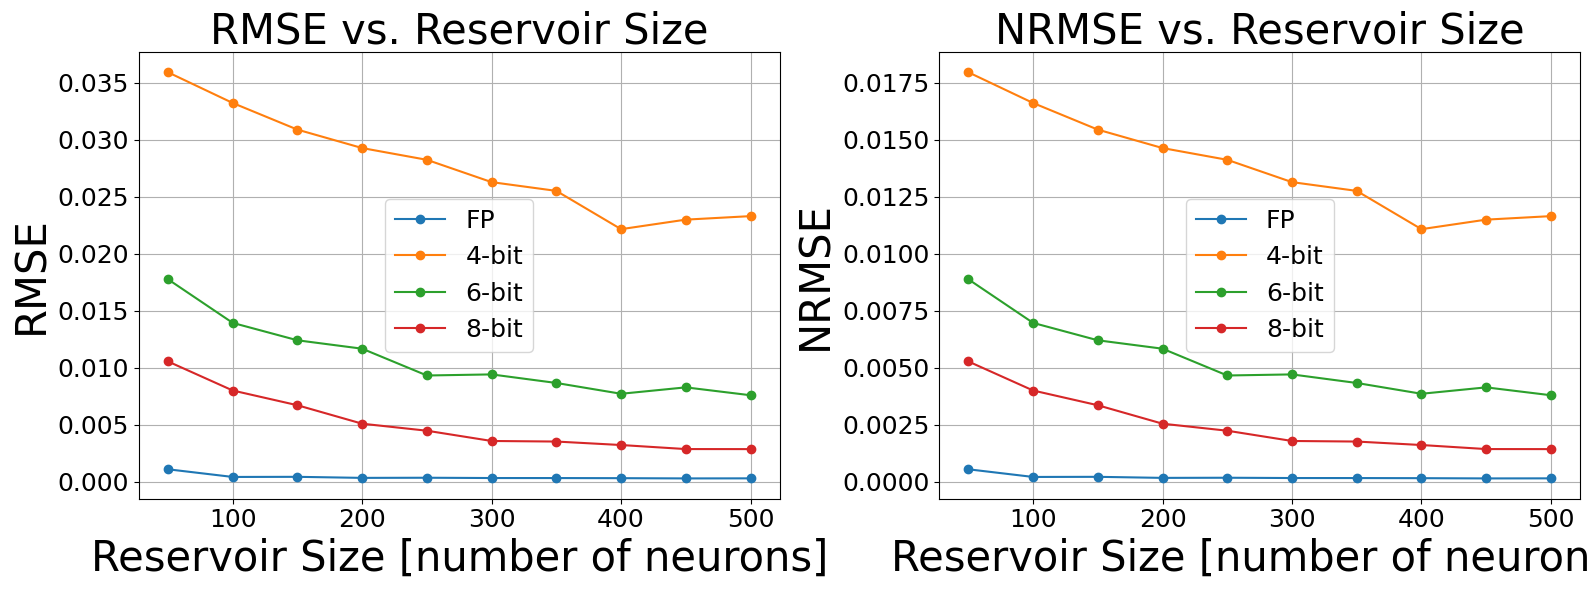

In [11]:
import matplotlib.pyplot as plt

metrics = ['RMSE', 'NRMSE']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for bits in ['FP', 4, 6, 8]:
        subset = df_results[df_results['bits'] == bits]
        # only add "-bit" suffix for the numeric entries
        if bits == 'FP':
            label = 'FP'
        else:
            label = f"{bits}-bit"
        ax.plot(subset['N'], subset[metric], marker='o', label=label)

    ax.set_title(f"{metric} vs. Reservoir Size", fontsize=30)
    ax.set_xlabel("Reservoir Size [number of neurons]", fontsize=30)
    ax.set_ylabel(metric, fontsize=30)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True)
    ax.legend(fontsize=18)

plt.tight_layout()
plt.savefig("rossler.pdf", bbox_inches='tight')
plt.show()


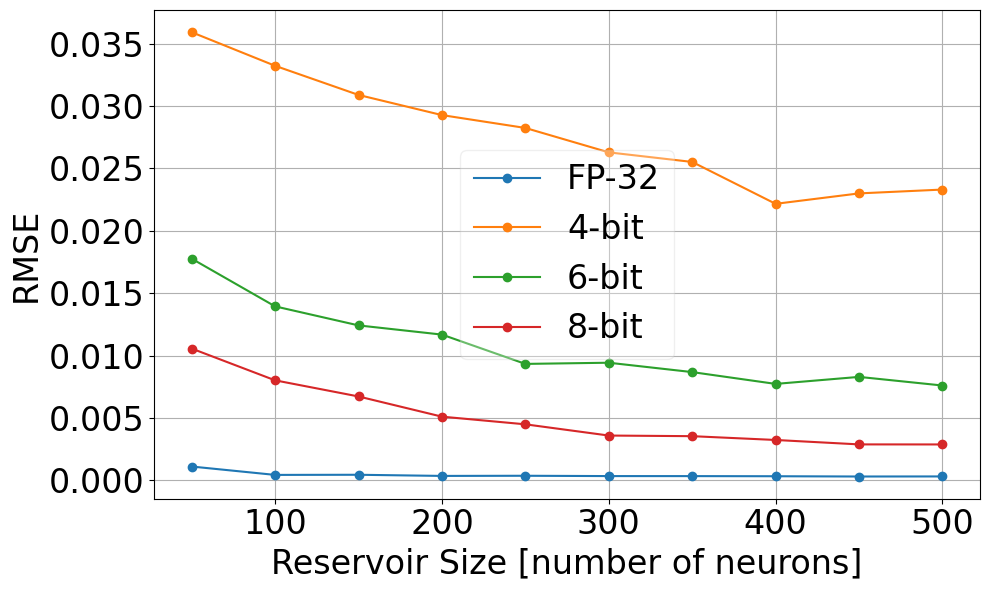

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for bits in ['FP', 4, 6, 8]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"
    plt.plot(subset['N'], subset['RMSE'], marker='o', label=label)

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.tight_layout()

# Transparent legend and more space from top
plt.legend(fontsize=24, framealpha=0.3, loc='center')

plt.savefig("rossler.pdf", bbox_inches='tight')
plt.show()

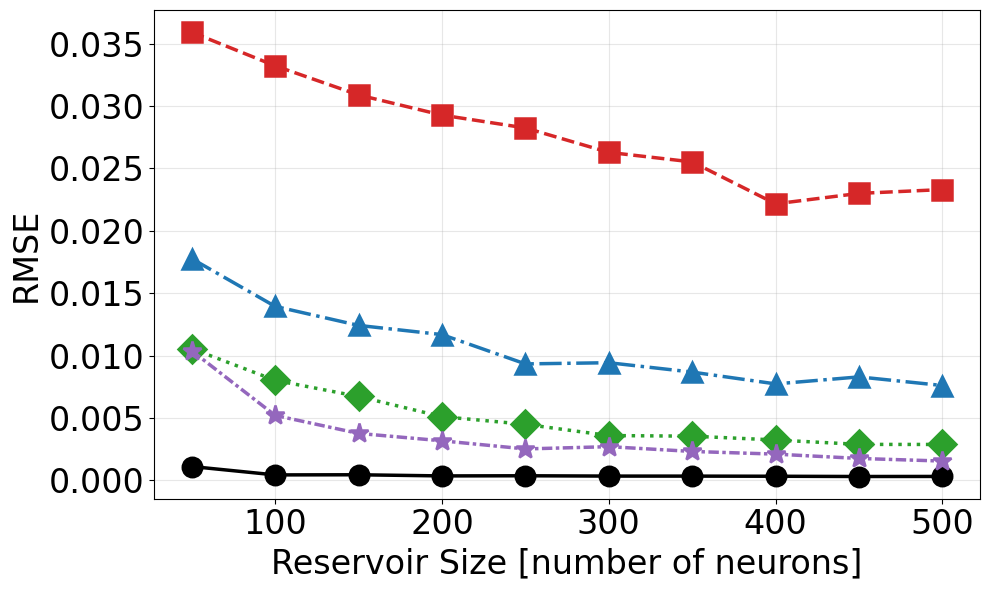

In [13]:
import matplotlib.pyplot as plt

# Define styles
styles = {
    'FP':  dict(color='black',      linestyle='-',  marker='o'),
    4:     dict(color='tab:red',    linestyle='--', marker='s'),
    6:     dict(color='tab:blue',   linestyle='-.', marker='^'),
    8:     dict(color='tab:green',  linestyle=':',  marker='D'),
    16:    dict(color='tab:purple', linestyle=(0, (3, 1, 1, 1)), marker='*')
}

plt.figure(figsize=(10, 6))

for bits in ['FP', 4, 6, 8, 16]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"

    plt.plot(
        subset['N'],
        subset['RMSE'],
        label=label,
        linewidth=2.5,
        markersize=14,          # bigger markers
        markeredgewidth=1.8,    # thicker marker border

        **styles[bits]
    )

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("rossler_R.pdf", bbox_inches='tight')
plt.show()


In [14]:
print("R\u00B2")

R²
